In [53]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:

# Specify the path to your JSON file
file_path = 'complaints-2021-05-14_08_16_.json'

# Open the JSON file
with open(file_path, 'r') as file:
    # Load the JSON data
    data = json.load(file)

# Convert the JSON data to a pandas DataFrame
df = pd.DataFrame(data)

# Now you can work with the DataFrame
# For example, you can access a specific field

In [56]:
data_ = pd.read_json('complaints-2021-05-14_08_16_.json')
dfs: pd.DataFrame = data_["_source"].apply(pd.Series)

In [58]:
dfs.head()

,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [61]:
selected_columns = ['complaint_id', 'issue', 'date_received', 'product', 'company_response', 'company', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']

# Create a new DataFrame with only the selected columns
dfs= dfs[selected_columns]

# View the first few rows of the new DataFrame
dfs.head()

,complaint_id,issue,date_received,product,company_response,company,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Conventional home mortgage,Yes,,None,Consent not provided
4,3203545,Fees or interest,2019-04-05T12:00:00-05:00,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [63]:
dfs.shape

(78313, 11)

In [65]:
dfs.isnull().sum()

complaint_id                     0
issue                            0
date_received                    0
product                          0
company_response                 0
company                          0
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

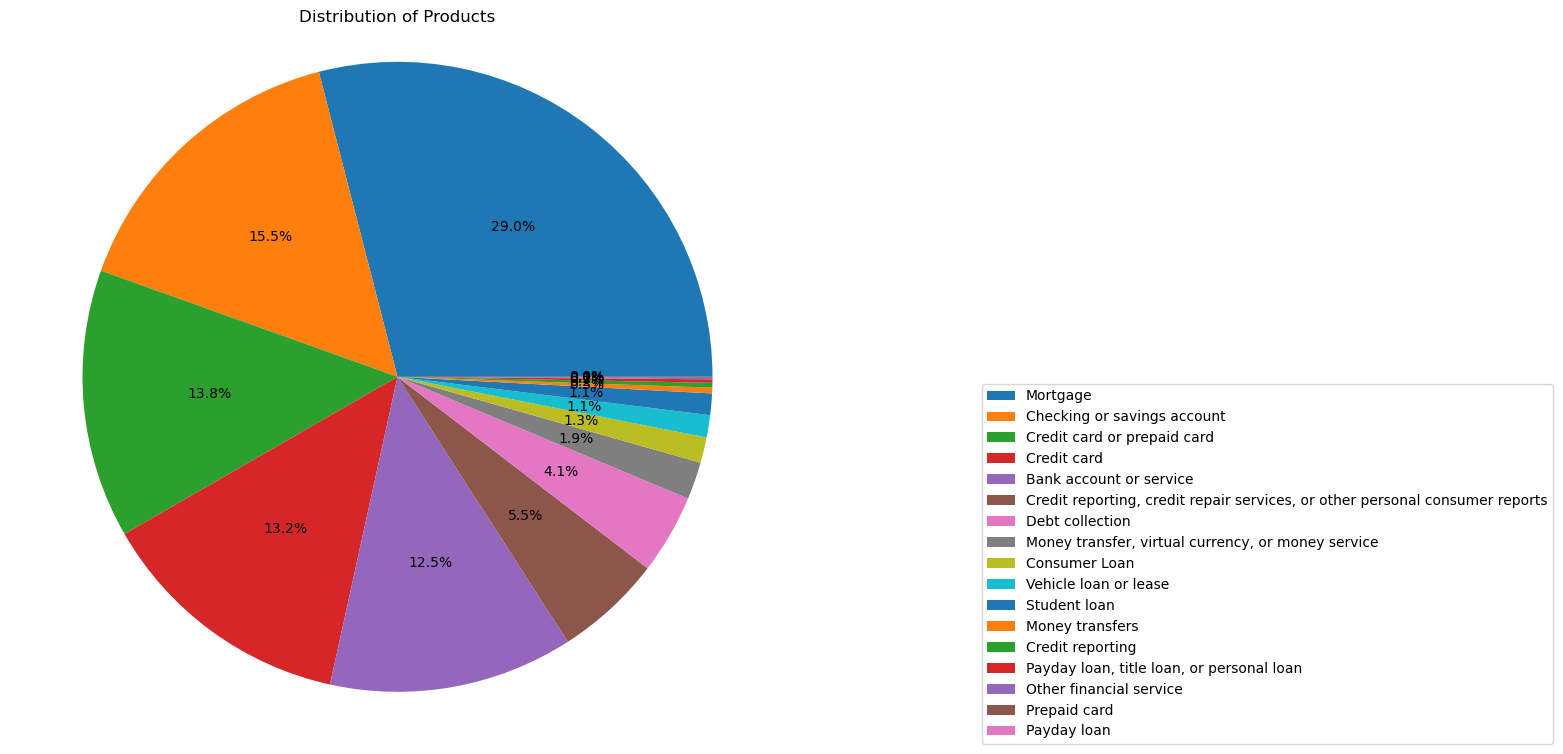

In [89]:
# Count the occurrences of each product
product_counts = dfs['product'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 9))
plt.pie(product_counts, labels=None, autopct='%1.1f%%')
plt.title('Distribution of Products')
plt.axis('equal')

# Create a legend for the pie chart
plt.legend(labels=product_counts.index, loc='upper right', bbox_to_anchor=(2, 0.5))

plt.show()

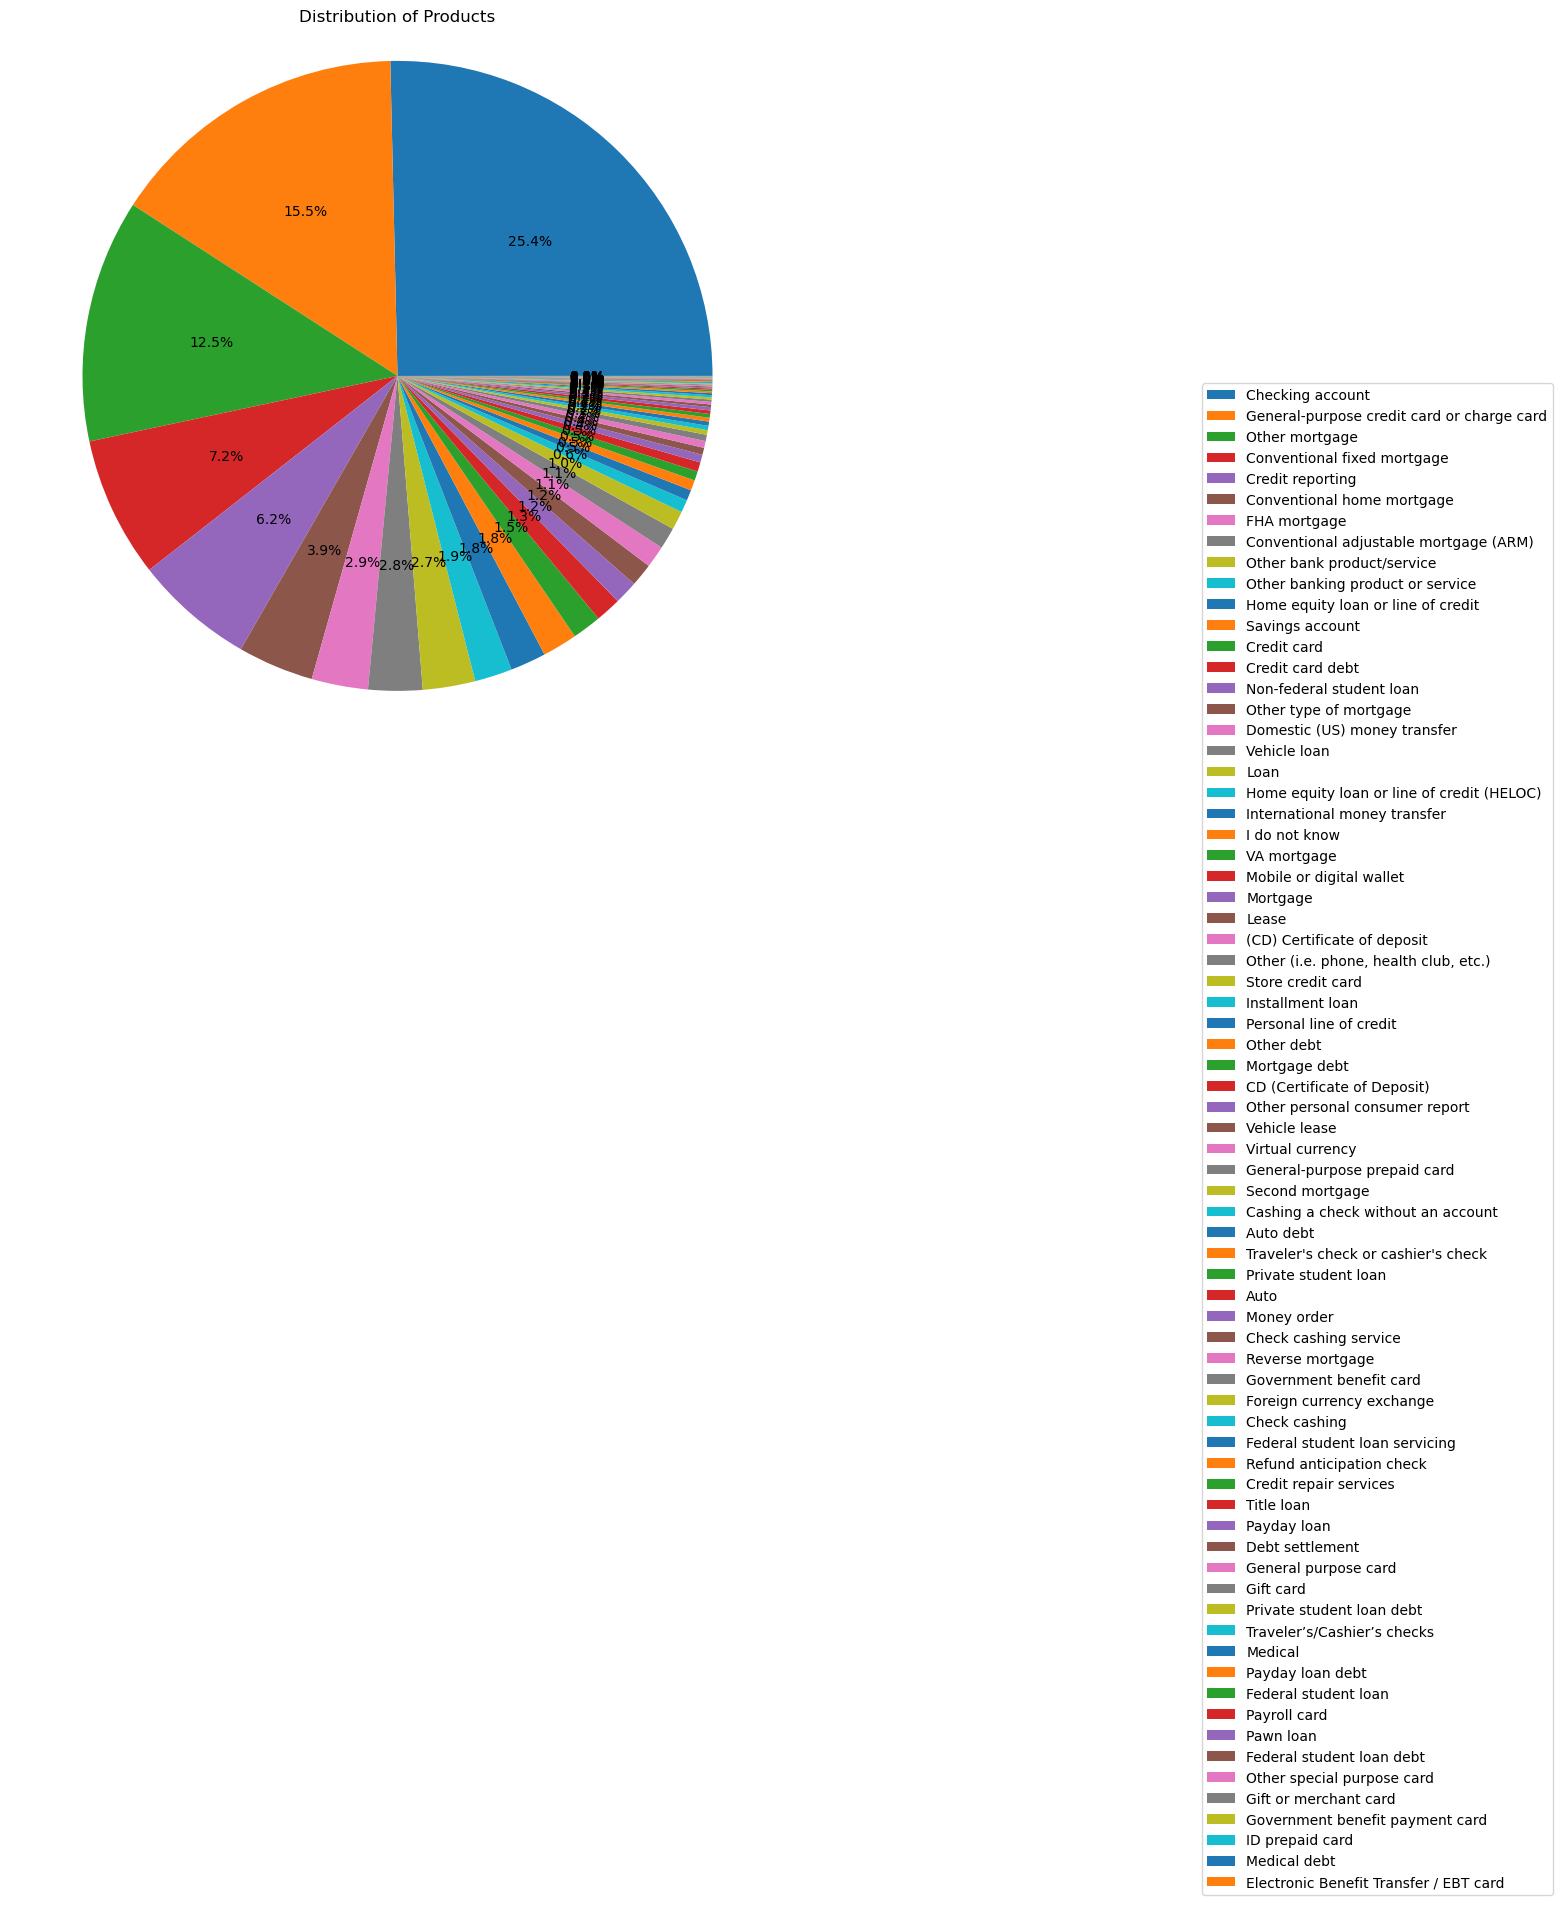

In [101]:
# Count the occurrences of each product
product_counts = dfs['sub_product'].value_counts()

# Plot the pie chart
plt.figure(figsize=(10, 9))
plt.pie(product_counts, labels=None, autopct='%1.1f%%')
plt.title('Distribution of Products')
plt.axis('equal')

# Create a legend for the pie chart
plt.legend(labels=product_counts.index, loc='upper right', bbox_to_anchor=(2, 0.5))

plt.show()

In [25]:
null_values = dfs['product'].isnull().sum()

# Print the number of null values
print("Number of null values in the 'product' column:", null_values)

Number of null values in the 'product' column: 0


In [113]:
dfs['complaint_what_happened'][5]

''

In [131]:
dfs['product'].nunique()

17